In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import netCDF4 as nc
import statistics
from scipy.spatial import KDTree
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import geopandas as gpd
import dask
import dask.array as da
import xarray as xr
import csv
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta

In [2]:
''' Coords of box '''
location = 2 # 0: Alatna, 1: Huslia, 

centers  = [[-153.65, 66.70], # Alatna (2, 3572)
            [-155.69, 66.01], # Huslia (2, 3612)
            [-157.01, 66.96], # (2, 3548)
            [-157.82, 65.81], # (2, 3630)
            [-158.34, 65.23], # (2, 3674)
            [-153.05, 67.12], # (2, 3537)
            [-152.30, 67.12], # (2, 3539)
            [-150.92, 66.71], # (2, 3568)
            [-146.44, 66.96], # (2, 3550) 
            [-153.26, 64.53]] # (2, 3728)

min_lon = centers[location][0] - .65
max_lon = centers[location][0] + .65
min_lat = centers[location][1] - .25
max_lat = centers[location][1] + .25

<IPython.core.display.Javascript object>


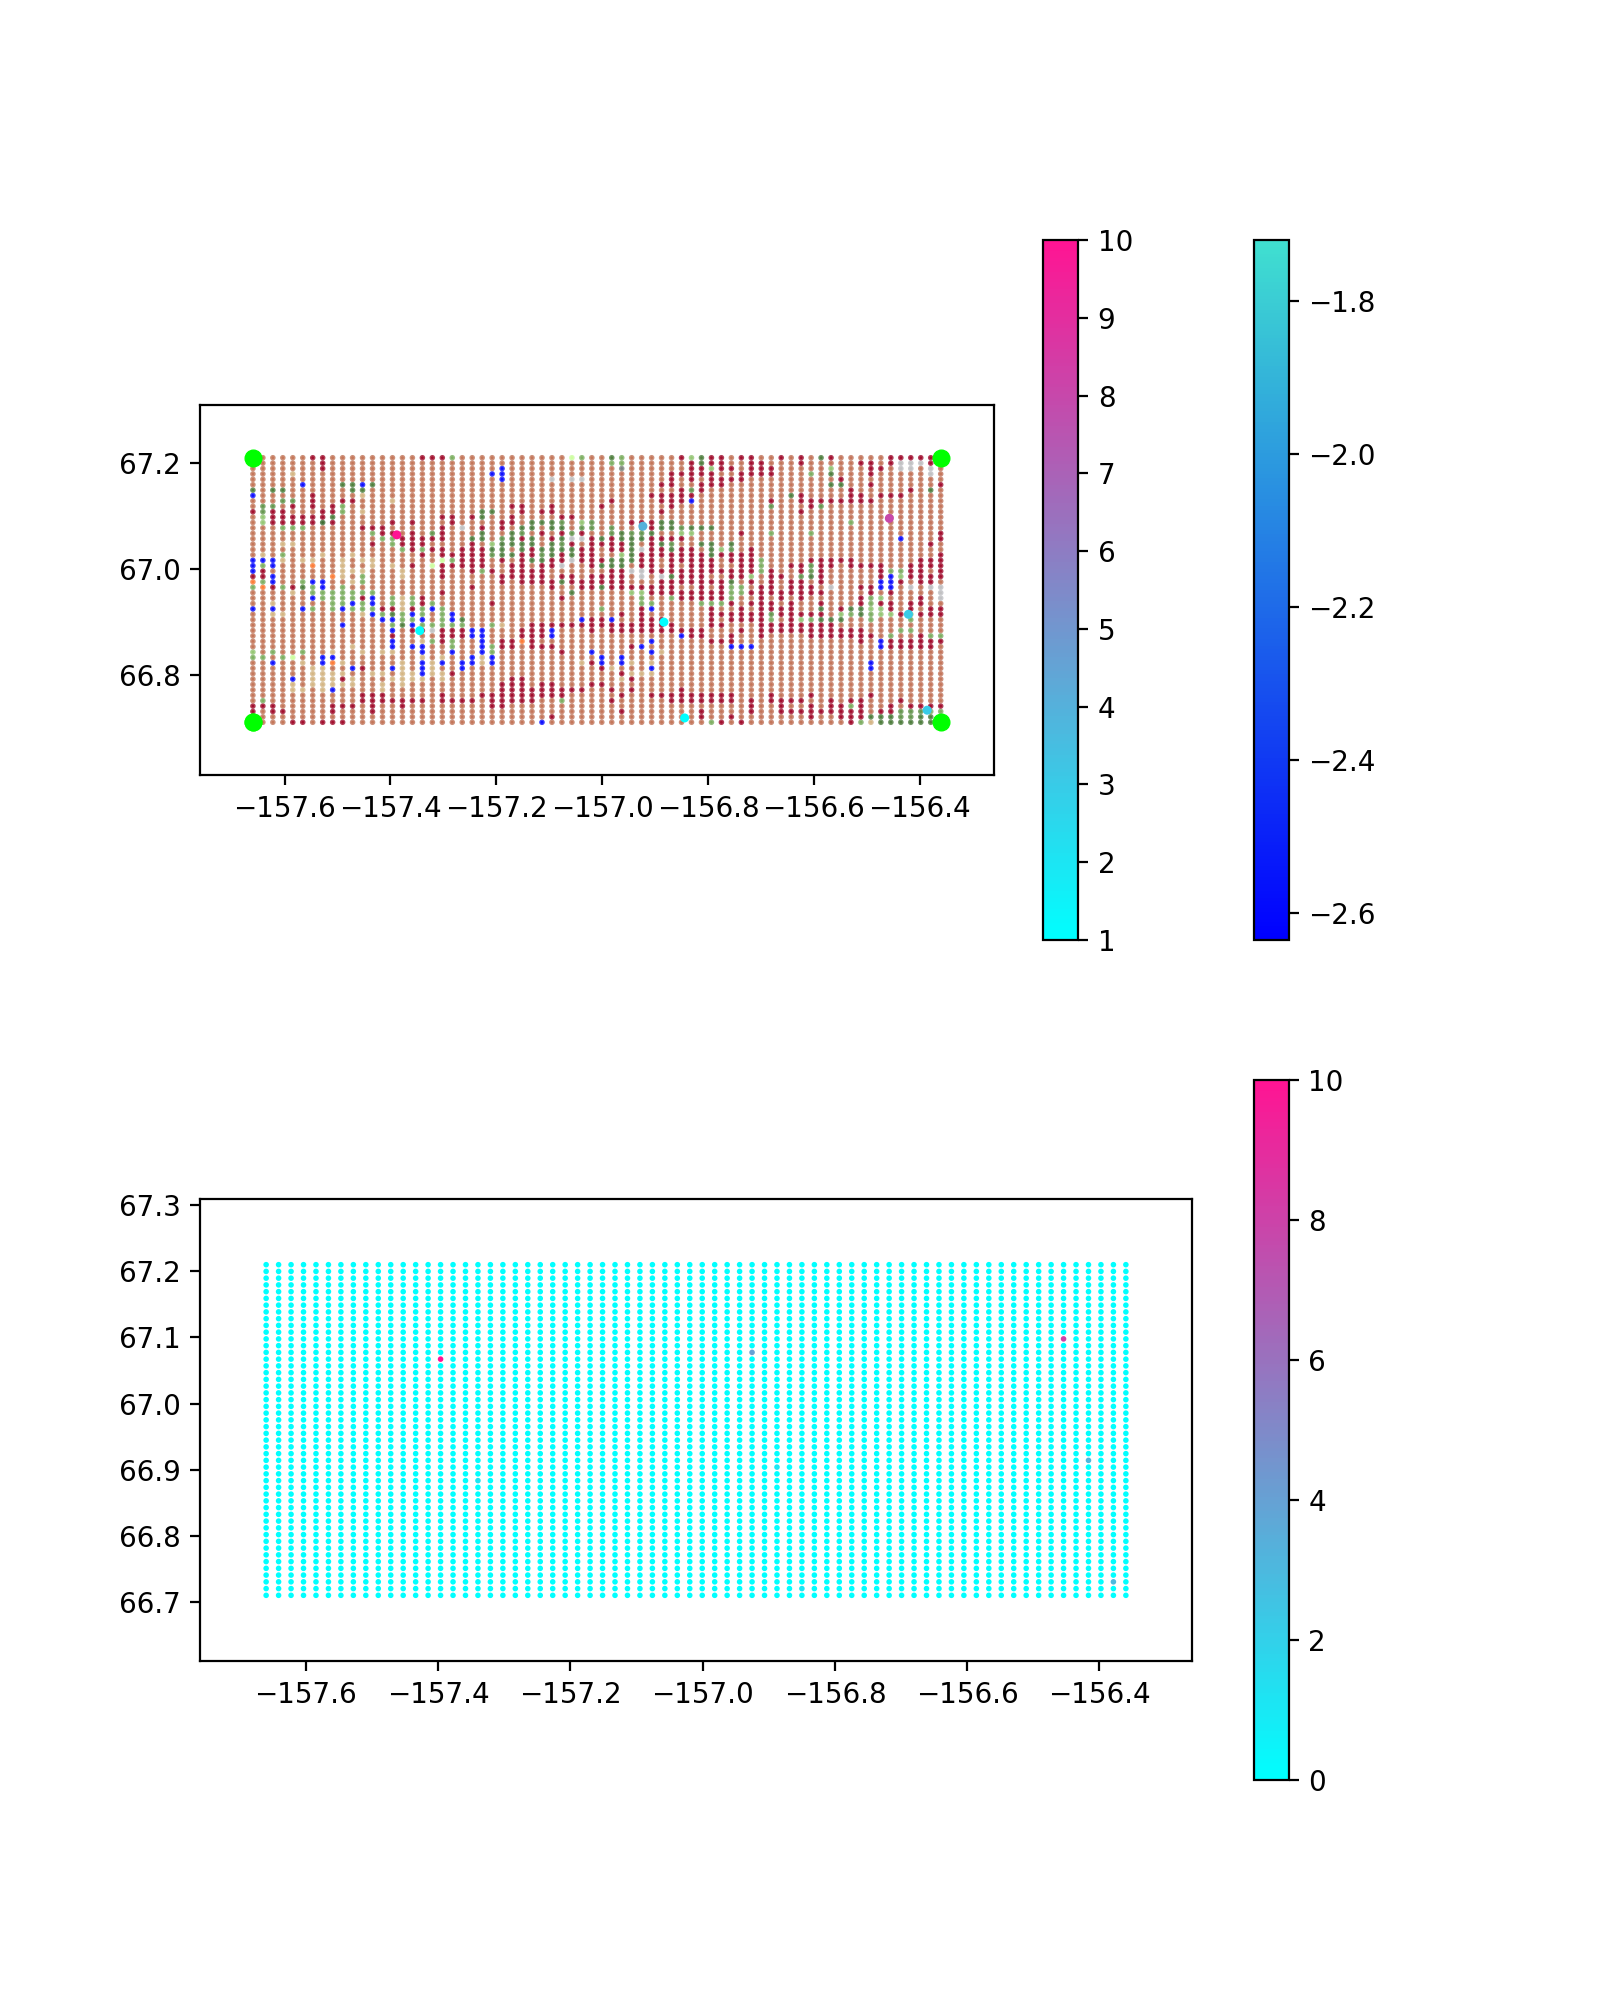

(66.61, 67.30999999999999)

In [3]:
fig, ax  = plt.subplots(2, figsize=(8, 10))

ax[0].set_xlim(min_lon - .1, max_lon + .1)
ax[0].set_ylim(min_lat - .1, max_lat + .1)
ax[1].set_xlim(min_lon - .1, max_lon + .1)
ax[1].set_ylim(min_lat - .1, max_lat + .1)

## Get temp data

In [4]:
tmax_files = ["/Users/joshuamiller/Documents/SULI 2023/Data/Alatna_Box/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Huslia_Box/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc"]

In [5]:
f = nc.Dataset(tmax_files[location], "r")
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

lat_tmax = f.variables["lat"] # Pointer to variable
lat_tmax = np.array(lat_tmax[:]) # : Extracts the numbers

lon_tmax = f.variables["lon"]
lon_tmax = np.array(lon_tmax[:])

time_tmax = f.variables["time"]
time_tmax = np.array(time_tmax[:])

tmax = f.variables["tmax"]
tmax = np.array(tmax[:])

f.close()

dict_keys(['time', 'x', 'y'])
dict_keys(['lat', 'lon', 'time', 'tmax'])


In [6]:
print(np.shape(lat_tmax), np.shape(lon_tmax), min(lat_tmax.ravel()), max(lat_tmax.ravel()), min(lon_tmax.ravel()), max(lon_tmax.ravel()), np.shape(tmax))

(70, 50) (70, 50) 66.71 67.21 -157.66 -156.36 (365, 70, 50)


In [7]:
#print(time_tmax)

In [8]:
''' Get points for the temp plot '''
points_tmax = [Point(xy) for xy in zip(lon_tmax.ravel(), lat_tmax.ravel())]
points_tmax_gdf = gpd.GeoDataFrame(geometry=points_tmax)

In [9]:
date = 300

tmax_gdf = gpd.GeoDataFrame(geometry=points_tmax).assign(data=tmax[date, :].ravel())

print(tmax_gdf.head())

                      geometry   data
0  POINT (-157.66000 66.71000) -1.880
1  POINT (-157.66000 66.72021) -1.880
2  POINT (-157.66000 66.73041) -1.890
3  POINT (-157.66000 66.74062) -1.895
4  POINT (-157.66000 66.75082) -1.880


In [10]:
norm_tmax = Normalize(vmin=min(tmax_gdf['data']), vmax=max(tmax_gdf['data']))
cmap_tmax = LinearSegmentedColormap.from_list('custom', ['blue', 'turquoise'], N=200) # Higher N=more smooth

## Get lightning data

In [11]:
''' Get necessary files '''
strikes_files = ['/Users/joshuamiller/Documents/SULI 2023/Data/Alatna_Box/Lightning/Strikes_2016_1_1-2016_12_31_Alatna_subset_v100.nc',
                 '/Users/joshuamiller/Documents/SULI 2023/Data/Huslia_Box/Lightning/Strikes_2016_1_1-2016_12_31_Huslia_subset_v100.nc',
                 '/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Lightning/Strikes_2016_1_1-2016_12_31_Loc1_subset_v100.nc',
                 '/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Lightning/Strikes_2016_1_1-2016_12_31_Loc2_subset_v100.nc',
                 '/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Lightning/Strikes_2016_1_1-2016_12_31_Loc3_subset_v100.nc',
                 '/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Lightning/Strikes_2016_1_1-2016_12_31_Loc4_subset_v100.nc',
                 '/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Lightning/Strikes_2016_1_1-2016_12_31_Loc5_subset_v100.nc',
                 '/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Lightning/Strikes_2016_1_1-2016_12_31_Loc6_subset_v100.nc',
                 '/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Lightning/Strikes_2016_1_1-2016_12_31_Loc7_subset_v100.nc',
                 '/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Lightning/Strikes_2016_1_1-2016_12_31_Loc8_subset_v100.nc']

print(strikes_files[location])

/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Lightning/Strikes_2016_1_1-2016_12_31_Loc1_subset_v100.nc


In [12]:
#f.close()
f = nc.Dataset(strikes_files[location], "r")

# Print the dimensions of the file
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

for name in f.variables.keys():
    variable = f.variables[name]
    print(variable.units)

# Get the data for a variable
lat_strikes = f.variables["lat"] # Pointer to variable
lat_strikes = np.array(lat_strikes[:]) # : Extracts the numbers

lon_strikes = f.variables["lon"]
lon_strikes = np.array(lon_strikes[:])

time_strikes = f.variables["time"]
time_strikes = np.array(time_strikes[:])

strikes = f.variables["strikes"]
strikes = np.array(strikes[:])

#print(time_strikes)
# Close the file
f.close()

dict_keys(['time', 'x'])
dict_keys(['lat', 'lon', 'time', 'strikes'])
degrees north
degrees east
days since 2016-01-01 00:00:0.0
number


In [13]:
print(np.shape(lat_strikes), np.shape(lon_strikes), np.shape(time_strikes), min(lat_strikes.ravel()), max(lat_strikes.ravel()), min(lon_strikes.ravel()), max(lon_strikes.ravel()), np.shape(strikes))

(8,) (8,) (365,) 66.718185 67.09545 -157.38812 -156.38556 (365, 8)


In [14]:
''' Get points for the snow plot and box '''
points_strikes = [Point(xy) for xy in zip(lon_strikes.ravel(), lat_strikes.ravel())]
points_strikes_gdf = gpd.GeoDataFrame(geometry=points_strikes)

print(points_strikes_gdf.head())

                      geometry
0  POINT (-156.84401 66.71819)
1  POINT (-156.38556 66.73281)
2  POINT (-157.34464 66.88312)
3  POINT (-156.88315 66.89932)
4  POINT (-156.42102 66.91408)


In [15]:
''' Make geo dataframe '''
date = 1
print(strikes[date, :].ravel(), np.sum(strikes, axis=0))

sum_strikes = np.sum(strikes, axis=0)

strikes_gdf = gpd.GeoDataFrame(geometry=points_strikes).assign(data=sum_strikes)

[0. 0. 0. 0. 0. 0. 0. 0.] [ 1.  3.  1.  1.  3. 10.  4.  8.]


In [16]:
norm_strikes = Normalize(vmin=min(sum_strikes), vmax=max(sum_strikes))
cmap_strikes = LinearSegmentedColormap.from_list('custom', ['aqua', 'deeppink'], N=200) # Higher N=more smooth

## Get fire data (already kriged)

In [17]:
''' Get necessary files '''
thing = 0 # 0: EVC, 1: EVT, 2: EVH, 3: ECV_2014, 4: ECT_2014, 5: EVH_2014

filenames = ["/Users/joshuamiller/Documents/SULI 2023/Data/Alatna_Box/Land_Fire/EVC_2014_Alatna_krig_grid.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/Huslia_Box/Land_Fire/EVC_2014_Huslia_krig_grid.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Land_Fire/EVC_2014_Loc1_krig_grid.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Land_Fire/EVC_2014_Loc2_krig_grid.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Land_Fire/EVC_2014_Loc3_krig_grid.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Land_Fire/EVC_2014_Loc4_krig_grid.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Land_Fire/EVC_2014_Loc5_krig_grid.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Land_Fire/EVC_2014_Loc6_krig_grid.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Land_Fire/EVC_2014_Loc7_krig_grid.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Land_Fire/EVC_2014_Loc8_krig_grid.csv"]

col_names = 'EVC_2014'

key_path  = "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVC_2014/AK_140_EVC/CSV_Data/ak_140evc.csv"

filename = filenames[location]
key_df = pd.read_csv(key_path)

In [18]:
print(key_df.head())

   VALUE                         CLASSNAMES    R    G    B       red  \
0     11                         Open Water    0    0  255  0.000000   
1     12                           Snow/Ice  159  161  240  0.623529   
2     13  Developed-Upland Deciduous Forest   64   61  168  0.250980   
3     14  Developed-Upland Evergreen Forest   68   79  137  0.266667   
4     15      Developed-Upland Mixed Forest  102  119  205  0.400000   

      green      blue  
0  0.000000  1.000000  
1  0.631373  0.941176  
2  0.239216  0.658824  
3  0.309804  0.537255  
4  0.466667  0.803922  


In [19]:
fire_df = pd.read_csv(filename)


print('filename :', filename)

print('fire_df.head() =', fire_df.head())

filename : /Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Land_Fire/EVC_2014_Loc1_krig_grid.csv
fire_df.head() =    Unnamed: 0        lat     lon  EVC_2014
0           0  66.710000 -157.66     162.0
1           1  66.720210 -157.66     162.0
2           2  66.730410 -157.66     163.0
3           3  66.740616 -157.66     163.0
4           4  66.750820 -157.66     162.0


In [20]:
''' Get points for the snow plot and box '''
points_fire = [Point(xy) for xy in zip(fire_df['lon'], fire_df['lat'])]
points_fire_gdf = gpd.GeoDataFrame(geometry=points_fire)

In [21]:
''' Get rgb values '''
key_dict = {}
for i in range(key_df.shape[0]):
    key_dict[key_df.loc[i, "VALUE"]] = np.array([key_df.loc[i, 'red'], key_df.loc[i, 'green'], key_df.loc[i, 'blue']])
#print(key_dict)

In [22]:
''' Convert integers to rgbs '''
rgbs = np.empty((fire_df.shape[0], 3), float)
for i in range(fire_df.shape[0]):
    pix = fire_df[col_names][i]
    #print("pix =", pix)
    for k in range(3):
        rgbs[i][k] = key_dict[pix][k]

In [23]:
rgbs = rgbs.reshape(fire_df.shape[0], 1, 3)
rgbs = rgbs.tolist()
print("shape =", np.shape(rgbs))

shape = (3500, 1, 3)


In [24]:
fire_gdf = gpd.GeoDataFrame(geometry=points_fire).assign(data=rgbs)

print(fire_gdf.head())

                      geometry                              data
0  POINT (-157.66000 66.71000)  [[0.760784, 0.431373, 0.309804]]
1  POINT (-157.66000 66.72021)  [[0.760784, 0.431373, 0.309804]]
2  POINT (-157.66000 66.73041)        [[0.619608, 0.0, 0.12549]]
3  POINT (-157.66000 66.74062)        [[0.619608, 0.0, 0.12549]]
4  POINT (-157.66000 66.75082)  [[0.760784, 0.431373, 0.309804]]


## Plot normal

In [25]:
''' Corners of the box of interest '''
box_lon = np.array([min_lon, max_lon, max_lon, min_lon, min_lon])
box_lat = np.array([min_lat, min_lat, max_lat, max_lat, min_lat])

print(max(box_lon), min(box_lon))

points_box = [Point(xy) for xy in zip(box_lon, box_lat)]
points_box_gdf = gpd.GeoDataFrame(geometry=points_box)

-156.35999999999999 -157.66


In [26]:
tmax_gdf.plot(ax=ax[0], column='data', cmap=cmap_tmax, norm=norm_tmax, markersize=1, alpha=.05, legend=True)

plt.draw()

In [27]:
fire_gdf.plot(ax=ax[0], color=[rgb for rgb in fire_gdf['data']], markersize=1, alpha=.75)

plt.draw()

In [28]:
strikes_gdf.plot(ax=ax[0], column='data', cmap=cmap_strikes, norm=norm_strikes, markersize=5, alpha=1, legend=True)

plt.draw()

In [29]:
points_box_gdf.plot(ax=ax[0], color='lime', edgecolor='lime', linewidth=.5, alpha=1)

plt.draw()

## Perform kriging

In [30]:
''' Create tree '''
lon_tmax_flat = lon_tmax.ravel()
lat_tmax_flat = lat_tmax.ravel()

print(np.array([lon_tmax_flat, lat_tmax_flat]).T.reshape(-1,2))

tree = KDTree(np.array([lon_tmax_flat, lat_tmax_flat]).T.reshape(-1,2))

[[-157.66      66.71   ]
 [-157.66      66.72021]
 [-157.66      66.73041]
 ...
 [-156.36      67.18959]
 [-156.36      67.1998 ]
 [-156.36      67.21   ]]


In [31]:
''' Locate the nearest point in tmax to the lightning strikes and set all other points to 0 '''
new_strikes = np.zeros((np.shape(strikes)[0], np.shape(tmax)[1] * np.shape(tmax)[2]), dtype=float)
print(np.shape(new_strikes), np.shape(strikes))

for i in range(np.shape(strikes)[1]):
    print("---------------------------------")
    ''' Get closest neighbor to desired point in tmax '''
    point = np.array([lon_strikes[i], lat_strikes[i]])
    
    dis, idx = tree.query(point)
    
    lon_krig = lon_tmax_flat[idx]
    lat_krig = lat_tmax_flat[idx]
    for t in range(np.shape(strikes)[0]):
        val_krig = strikes[t][i]

        print("i =", i, ", idx =", idx, ", val =", val_krig, ", point =", point, " lon =", lon_krig, ", lat =", lat_krig)
    
        new_strikes[t][idx] = val_krig

(365, 3500) (365, 8)
---------------------------------
i = 0 , idx = 2151 , val = 0.0 , point = [-156.84401    66.718185]  lon = -156.84985 , lat = 66.72021
i = 0 , idx = 2151 , val = 0.0 , point = [-156.84401    66.718185]  lon = -156.84985 , lat = 66.72021
i = 0 , idx = 2151 , val = 0.0 , point = [-156.84401    66.718185]  lon = -156.84985 , lat = 66.72021
i = 0 , idx = 2151 , val = 0.0 , point = [-156.84401    66.718185]  lon = -156.84985 , lat = 66.72021
i = 0 , idx = 2151 , val = 0.0 , point = [-156.84401    66.718185]  lon = -156.84985 , lat = 66.72021
i = 0 , idx = 2151 , val = 0.0 , point = [-156.84401    66.718185]  lon = -156.84985 , lat = 66.72021
i = 0 , idx = 2151 , val = 0.0 , point = [-156.84401    66.718185]  lon = -156.84985 , lat = 66.72021
i = 0 , idx = 2151 , val = 0.0 , point = [-156.84401    66.718185]  lon = -156.84985 , lat = 66.72021
i = 0 , idx = 2151 , val = 0.0 , point = [-156.84401    66.718185]  lon = -156.84985 , lat = 66.72021
i = 0 , idx = 2151 , val = 

In [32]:
new_strikes = np.reshape(new_strikes, (np.shape(tmax)[0], np.shape(tmax)[1], np.shape(tmax)[2]))

In [33]:
new_strikes_files = ['/Users/joshuamiller/Documents/SULI 2023/Data/Alatna_Box/Lightning/strikes_Alatna_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Huslia_Box/Lightning/strikes_Huslia2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Lightning/strikes_Loc1_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Lightning/strikes_Loc2_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Lightning/strikes_Loc3_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Lightning/strikes_Loc4_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Lightning/strikes_Loc5_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Lightning/strikes_Loc6_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Lightning/strikes_Loc7_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Lightning/strikes_Loc8_2016_1_1-2016_12_31_krig_grid.nc']

In [34]:
''' Write da file '''
#ncfile.close()
#f.close()
ncfile = nc.Dataset(new_strikes_files[location], 'w', format='NETCDF4')

# Create dimensions
ncfile.createDimension('time', new_strikes.shape[0])
ncfile.createDimension('x', new_strikes.shape[1])
ncfile.createDimension('y', new_strikes.shape[2])

# Create variables
lat_var = ncfile.createVariable('lat', 'f4', ('x','y'))
lon_var = ncfile.createVariable('lon', 'f4', ('x','y'))
time_var = ncfile.createVariable('time', 'i4', ('time',)) # Orig. i4
strikes_var = ncfile.createVariable('strikes', 'f4', ('time','x','y'))

lat_var.setncattr('dimensions', 'x' 'y')
lon_var.setncattr('dimensions', 'x' 'y')
time_var.setncattr('dimensions', 'time')
strikes_var.setncattr('dimensions', 'time' 'x' 'y')

# Assign values to variables
lat_var[:] = lat_tmax
lon_var[:] = lon_tmax
time_var[:] = np.arange(0, new_strikes.shape[0]) # 0, 1, 2, ..., 365
strikes_var[:] = new_strikes

# Add variable attributes
lat_var.units = 'degrees north'
lon_var.units = 'degrees east'
time_var.units = 'days since 2016-01-01 00:00:00'
strikes_var.units = 'number'

# Close the file
ncfile.close()

## Extract data for plotting

In [35]:
#ncfile.close()

f = nc.Dataset(new_strikes_files[location], "r")
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

lat_strikes_krig = f.variables["lat"] # Pointer to variable
lat_strikes_krig = np.array(lat_strikes_krig[:]) # : Extracts the numbers

lon_strikes_krig = f.variables["lon"]
lon_strikes_krig = np.array(lon_strikes_krig[:])

time_strikes_krig = f.variables["time"]
time_strikes_krig = np.array(time_strikes_krig[:])

strikes_krig = f.variables["strikes"]
strikes_krig = np.array(strikes_krig[:])

for variable_name in f.variables.keys():
    variable = f.variables[variable_name]
    print(f"{variable_name} units: {variable.units}")

f.close()

dict_keys(['time', 'x', 'y'])
dict_keys(['lat', 'lon', 'time', 'strikes'])
lat units: degrees north
lon units: degrees east
time units: days since 2016-01-01 00:00:00
strikes units: number


In [36]:
print(np.shape(lat_strikes_krig), np.shape(lon_strikes_krig), min(lat_strikes_krig.ravel()), max(lat_strikes_krig.ravel()), min(lon_strikes_krig.ravel()), max(lon_strikes_krig.ravel()), np.shape(strikes_krig))

(70, 50) (70, 50) 66.71 67.21 -157.66 -156.36 (365, 70, 50)


In [37]:
date = 51
print(np.shape(strikes_krig))

sum_strikes_krig = np.reshape(strikes_krig, (np.shape(strikes_krig)[0], -1))
print(np.shape(sum_strikes_krig))

sum_strikes_krig = np.sum(sum_strikes_krig, axis=0)
print(np.shape(sum_strikes_krig))

strikes_kriged_gdf = gpd.GeoDataFrame(geometry=points_tmax).assign(data=sum_strikes_krig)

(365, 70, 50)
(365, 3500)
(3500,)


In [38]:
norm_strikes_krig = Normalize(vmin=min(sum_strikes_krig), vmax=max(sum_strikes_krig))
cmap_strikes_krig = LinearSegmentedColormap.from_list('custom', ['aqua', 'deeppink'], N=200) # Higher N=more smooth

In [39]:
#tmax_gdf.plot(ax=ax[1], column='data', cmap=cmap_tmax, norm=norm_tmax, markersize=5, alpha=.05, legend=True)

#plt.draw()

In [40]:
strikes_kriged_gdf.plot(ax=ax[1], column='data', cmap=cmap_strikes_krig, norm=norm_strikes_krig, markersize=1, alpha=1, legend=True) 

plt.draw()